In [3]:
# Imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cv2
import os

import tensorflow as tf

import matplotlib.pyplot as plt

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPooling2D,AvgPool2D,GlobalAveragePooling2D,Dense,Dropout,BatchNormalization,Flatten,Input,ReLU,Softmax
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

from joblib import load

from PIL import Image

%matplotlib inline
import pylab # this allows you to control figure size
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Đường dẫn đến thư mục chứa ảnh
folder_path = '/kaggle/input/face-data/FaceData'

i=1
# Khởi tạo danh sách để lưu trữ ảnh đã chuyển đổi
images = []

# Khởi tạo mảng để lưu trữ nhãn của mỗi ảnh
labels = []

# Lặp qua tất cả các tệp tin trong thư mục
for filename in os.listdir(folder_path):
    filepath = os.path.join(folder_path, filename)

    # Đọc ảnh
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    # Chuyển kích thước về 100x100
    img_resized = cv2.resize(img, (100, 100))
    
    # Thêm ảnh đã chuyển đổi vào danh sách
    images.append(np.array(img_resized))

    # Trích xuất ký tự từ tên tệp và thêm vào mảng nhãn
    label = filename.split('_')[1]
    labels.append(label)

In [5]:
[label for label in labels if label not in ["0", "1"]]

['3']

In [6]:
index = labels.index("3")
index

8370

In [7]:
del images[index]
del labels[index]

In [8]:
print(len(images))
print(len(labels))

9779
9779


In [9]:
images = np.array(images)
labels = np.array(labels,np.uint64)
labels = labels[:, np.newaxis]
labels = labels.reshape(-1, 1)
print(len(images))
print(len(labels))

9779
9779


In [10]:
X_train, X1, y_train, y1 = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X1, y1, test_size=0.5, random_state=42)
# Xem kích thước của tập huấn luyện và tập kiểm thử
print("Kích thước tập huấn luyện:", len(X_train))
print("Kích thước tập kiểm thử:", len(X_test))
print("Kích thước tập kiểm thử:", len(X_val))

Kích thước tập huấn luyện: 6845
Kích thước tập kiểm thử: 1467
Kích thước tập kiểm thử: 1467


In [10]:
###################################################333

In [11]:
input = Input(shape = (100,100,1))

conv1 = Conv2D(32,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2)) (conv1)

conv2 = Conv2D(64,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2)) (conv2)

conv3 = Conv2D(128,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2)) (conv3)

conv4 = Conv2D(256,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2)) (conv4)

flatten = Flatten()(pool4)

dense_1 = Dense(128,activation='relu')(flatten)

drop_1 = Dropout(0.2)(dense_1)

output = Dense(2,activation="sigmoid")(drop_1)

model = Model(inputs=input,outputs=output)
model.compile(optimizer="adam",loss=["sparse_categorical_crossentropy"],metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                             

In [12]:
model_path='/kaggle/working/gender_model.h5'
checkpointer = ModelCheckpoint(model_path, monitor='loss',verbose=1,save_best_only=True,
                               save_weights_only=False, mode='auto',save_freq='epoch')
callback_list=[checkpointer]

In [13]:
save = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,callbacks=[callback_list])

Epoch 1/30


2024-01-09 02:35:39.621054: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


214/214 [==============================] - ETA: 0s - loss: 1.5897 - accuracy: 0.6491
Epoch 1: loss improved from inf to 1.58973, saving model to /kaggle/working/gender_model.h5
214/214 [==============================] - 11s 25ms/step - loss: 1.5897 - accuracy: 0.6491 - val_loss: 0.7383 - val_accuracy: 0.7226
Epoch 2/30
  4/214 [..............................] - ETA: 4s - loss: 0.8237 - accuracy: 0.6719

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


214/214 [==============================] - ETA: 0s - loss: 0.6989 - accuracy: 0.7322
Epoch 2: loss improved from 1.58973 to 0.69889, saving model to /kaggle/working/gender_model.h5
214/214 [==============================] - 5s 21ms/step - loss: 0.6989 - accuracy: 0.7322 - val_loss: 0.6403 - val_accuracy: 0.7744
Epoch 3/30
214/214 [==============================] - ETA: 0s - loss: 0.6136 - accuracy: 0.7778
Epoch 3: loss improved from 0.69889 to 0.61363, saving model to /kaggle/working/gender_model.h5
214/214 [==============================] - 4s 21ms/step - loss: 0.6136 - accuracy: 0.7778 - val_loss: 0.5997 - val_accuracy: 0.7798
Epoch 4/30
214/214 [==============================] - ETA: 0s - loss: 0.5628 - accuracy: 0.7944
Epoch 4: loss improved from 0.61363 to 0.56277, saving model to /kaggle/working/gender_model.h5
214/214 [==============================] - 4s 21ms/step - loss: 0.5628 - accuracy: 0.7944 - val_loss: 0.5781 - val_accuracy: 0.7805
Epoch 5/30
214/214 [===================

In [14]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = save.history['loss']
test_loss = save.history['val_loss']
train_accuracy = save.history['accuracy']
test_accuracy = save.history['val_accuracy']

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

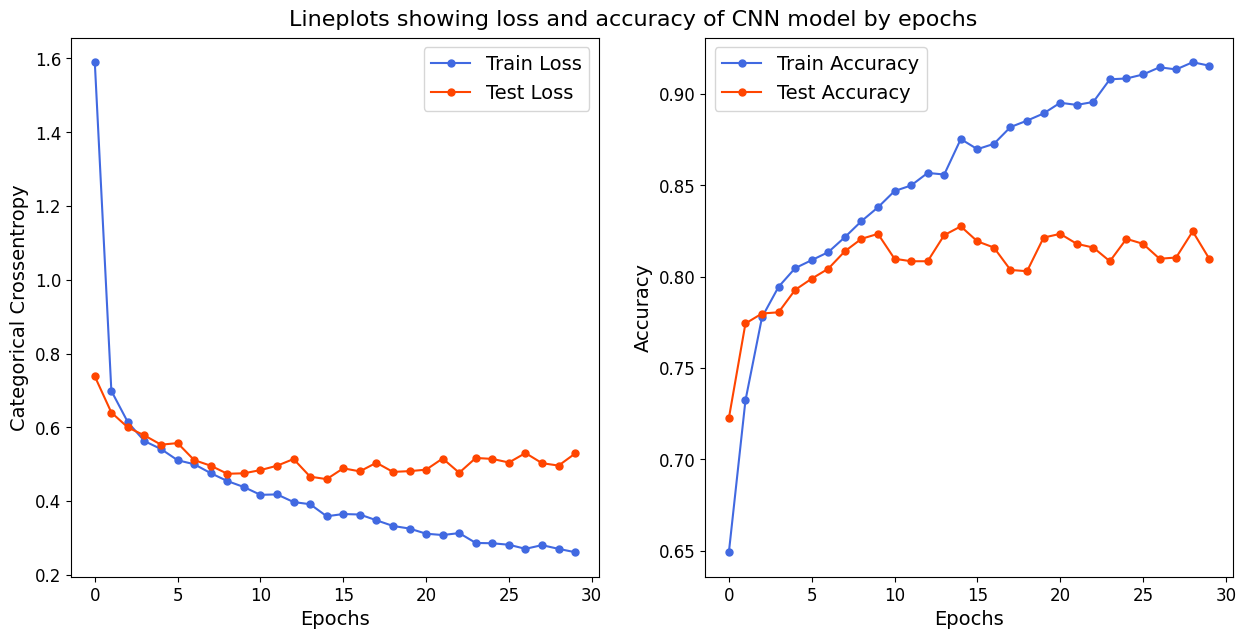

In [15]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

In [20]:
input = Input(shape = (100,100,1))

conv1 = Conv2D(32,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2)) (conv1)

conv2 = Conv2D(64,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2)) (conv2)

conv3 = Conv2D(128,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2)) (conv3)

conv4 = Conv2D(256,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2)) (conv4)

flatten = Flatten()(pool4)

dense_1 = Dense(128,activation='relu')(flatten)

drop_1 = Dropout(0.2)(dense_1)

output = Dense(2,activation="sigmoid")(drop_1)

model = Model(inputs=input,outputs=output)
model.compile(optimizer="adam",loss=["sparse_categorical_crossentropy"],metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 100, 32)      320       
                                                                 
 dropout_10 (Dropout)        (None, 100, 100, 32)      0         
                                                                 
 activation_8 (Activation)   (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 50, 50, 64)        18496     
                                                           

In [16]:
model_path='/kaggle/working/gender_model2.h5'

checkpointer = ModelCheckpoint(model_path, monitor='val_loss',verbose=1,save_best_only=True,
                               save_weights_only=False, mode='auto',save_freq='epoch')

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

callback_list2=[checkpointer, early_stopping]

In [17]:
save = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,callbacks=[callback_list2], batch_size=16)

Epoch 1/30


2024-01-10 02:25:23.723005: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


428/428 [==============================] - ETA: 0s - loss: 2.1140 - accuracy: 0.6593
Epoch 1: val_loss improved from inf to 1.36397, saving model to /kaggle/working/gender_model2.h5
428/428 [==============================] - 8s 13ms/step - loss: 2.1140 - accuracy: 0.6593 - val_loss: 1.3640 - val_accuracy: 0.6244
Epoch 2/30
427/428 [============================>.] - ETA: 0s - loss: 1.1052 - accuracy: 0.7516
Epoch 2: val_loss improved from 1.36397 to 0.97558, saving model to /kaggle/working/gender_model2.h5
428/428 [==============================] - 5s 12ms/step - loss: 1.1050 - accuracy: 0.7515 - val_loss: 0.9756 - val_accuracy: 0.7778
Epoch 3/30
426/428 [============================>.] - ETA: 0s - loss: 0.9037 - accuracy: 0.7789
Epoch 3: val_loss improved from 0.97558 to 0.84417, saving model to /kaggle/working/gender_model2.h5
428/428 [==============================] - 5s 12ms/step - loss: 0.9039 - accuracy: 0.7785 - val_loss: 0.8442 - val_accuracy: 0.7825
Epoch 4/30
426/428 [========

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

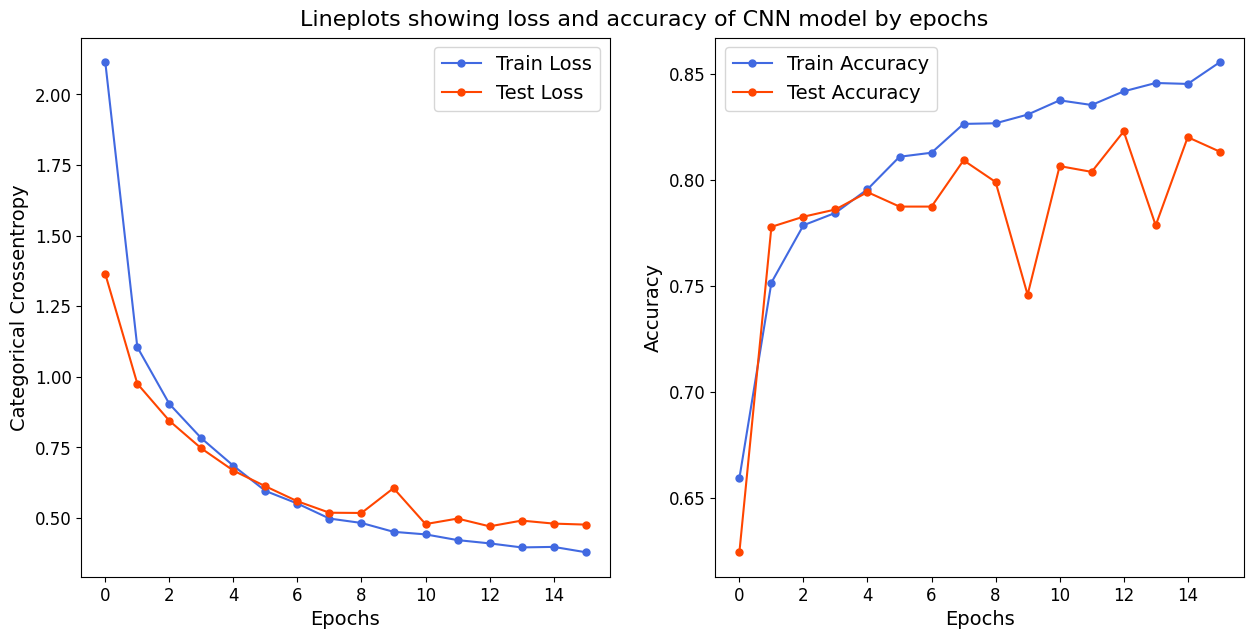

In [18]:
train_loss = save.history['loss']
test_loss = save.history['val_loss']
train_accuracy = save.history['accuracy']
test_accuracy = save.history['val_accuracy']

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

In [62]:
model_path1 = '/kaggle/working/gender_model.h5'
gender_model1 = load_model(model_path1)

results = gender_model1.evaluate(X_test, y_test)

# In kết quả
print("Loss on test set:", results[0])
print("Accuracy on test set:", results[1])

46/46 [==============================] - 0s 5ms/step - loss: 0.5292 - accuracy: 0.8098
Loss on test set: 0.5292496681213379
Accuracy on test set: 0.8098159432411194


In [19]:
model_path2 = '/kaggle/working/gender_model2.h5'
gender_model2 = load_model(model_path2)

results = gender_model2.evaluate(X_test, y_test)

# In kết quả
print("Loss on test set:", results[0])
print("Accuracy on test set:", results[1])

46/46 [==============================] - 1s 8ms/step - loss: 0.4703 - accuracy: 0.8228
Loss on test set: 0.4703371524810791
Accuracy on test set: 0.8227675557136536


In [56]:
model_path3 = '/kaggle/input/gender-model/gender_model.h5'
gender_model3 = load_model(model_path3)
results = gender_model3.evaluate(X_test, y_test)

# In kết quả
print("Loss on test set:", results[0])
print("Accuracy on test set:", results[1])

46/46 [==============================] - 0s 6ms/step - loss: 0.3149 - accuracy: 0.8991
Loss on test set: 0.3149012327194214
Accuracy on test set: 0.8991138339042664


gender model 1 là model gốc được train lại theo dataset mới (Face Data)

gender model 2 là model được sửa đổi, train trên Face Data

gender model 3 là model gốc train trên dataset UTKFace

Face Data chứa 9780 ảnh, trong đó có 1 ảnh lỗi nên còn 9779 ảnh

UTKFace có 23708 ảnh